# Capstone 3: Deep Neural Network Modeling & Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt

In [2]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [3]:
from keras.models import Sequential
from keras.layers import Dense

In [4]:
import tensorflow as ts

In [5]:
np.random.seed(42)

In [6]:
df_train = pd.read_csv('train.csv')

Since I have already gotten an idea of what the data looks like from the EDA, I am removing columns that do not have pertinant information to genetic disorders such as the Patient ID, Patient Name, Family Name, Father's name, Institute name and location, status, Place of birth, and unknown test indicators.

In [7]:
# off the bat we can drop the patients, and parents names, as well as the institue and the name of the institute as 
# this does not affect genetic outcome
df_train.drop(['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
           'Institute Name', 'Institute Name', 'Location of Institute', 'Status', 'Place of birth','Test 1','Test 2','Test 3',
            'Test 4','Test 5'
           ], axis = 1, inplace = True)

df_train = df_train.rename(columns = {'Patient Age':'Patient_Age', "Genes in mother's side":"Genes_in_mothers_side",
            'Inherited from father':'Inherited_from_father',
            'Maternal gene':'Maternal_gene', 'Paternal gene':'Paternal_gene',
            'Blood cell count (mcL) ':'Blood_cell_count', "Father's age":'Fathers_age', "Mother's age":'Mothers_age',
            'Respiratory Rate (breaths/min)':'Respiratory_Rate', 'Heart Rate (rates/min':'Heart_Rate',
            'Test 1':'Test_1', 'Test 2':'Test_2', 'Test 3':'Test_3',
            'Test 4':'Test_4', 'Test 5':'Test_5', 'Parental consent': 'Parental_consent', 'Follow-up':'Follow_up', 
             'Birth asphyxia':'Birth_asphyxia',
             'Autopsy shows birth defect (if applicable)': 'Autopsy_shows_birth_defect', 
             'Folic acid details (peri-conceptional)':'Folic_acid_details', 
            'H/O serious maternal illness':'HO_serious_maternal_illness',
            'H/O radiation exposure (x-ray)':'HO_radiation_exposure', 'H/O substance abuse':'HO_substance_abuse',
            'Assisted conception IVF/ART':'Assisted_conception_IVFART', 
            'History of anomalies in previous pregnancies':'History_of_anomalies_in_previous_pregnancies',
            'No. of previous abortion':'No_of_previous_abortion', 'Birth defects':'Birth_defects', 
            'White Blood cell count (thousand per microliter)':'White_Blood_cell_count', 
            'Blood test result':'Blood_test_result',
            'Symptom 1':'Symptom_1', 'Symptom 2':'Symptom_2', 'Symptom 3':'Symptom_3', 'Symptom 4':'Symptom_4', 
            'Symptom 5':'Symptom_5',
            'Genetic Disorder':'Genetic_Disorder', 'Disorder Subclass':'Disorder_Subclass', 
            'Blood cell count (mcL)': 'Blood_cell_count'})

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Patient_Age                                   20656 non-null  float64
 1   Genes_in_mothers_side                         22083 non-null  object 
 2   Inherited_from_father                         21777 non-null  object 
 3   Maternal_gene                                 19273 non-null  object 
 4   Paternal_gene                                 22083 non-null  object 
 5   Blood_cell_count                              22083 non-null  float64
 6   Mothers_age                                   16047 non-null  float64
 7   Fathers_age                                   16097 non-null  float64
 8   Respiratory_Rate                              19934 non-null  object 
 9   Heart_Rate                                    19970 non-null 

From the above info() call, it is clear there are missing values in the data. When working with a neural network it is important to have no missing values in the data. For most of the missing values I chose to use the method of backfilling and used that as consistently as I could to ensure some continuity over the filled values. For numeric values I chose to use the median to fill the values.

In [9]:
# Fill na values
df_train['Patient_Age'] = df_train['Patient_Age'].fillna(value = df_train['Patient_Age'].median())
df_train['Inherited_from_father'] = df_train['Inherited_from_father'].fillna(method = "backfill")
df_train['Maternal_gene'] = df_train['Maternal_gene'].fillna(method = 'backfill')
df_train["Mothers_age"] = df_train["Mothers_age"].fillna(value = df_train["Mothers_age"].median())
df_train["Fathers_age"] = df_train["Fathers_age"].fillna(value = df_train["Fathers_age"].median())
df_train["Respiratory_Rate"] = df_train["Respiratory_Rate"].fillna(method = 'backfill')
df_train["Heart_Rate"] = df_train["Heart_Rate"].fillna(method = 'backfill')
df_train['Parental_consent'] = df_train['Parental_consent'].fillna(value = 'No')
df_train['Follow_up'] = df_train['Follow_up'].fillna(method = 'backfill')
df_train['Gender'] = df_train['Gender'].fillna(method = 'backfill')
df_train['Birth_asphyxia'] = df_train['Birth_asphyxia'].fillna(method = 'backfill')
df_train['Autopsy_shows_birth_defect'] = df_train['Autopsy_shows_birth_defect'].fillna(value = 'Not applicable')
df_train['Folic_acid_details'] = df_train['Folic_acid_details'].fillna(method = 'backfill')
df_train['HO_serious_maternal_illness'] = df_train['HO_serious_maternal_illness'].fillna(method = 'backfill')
df_train['HO_radiation_exposure'] = df_train['HO_radiation_exposure'].fillna(value = 'Not applicable')
df_train['HO_substance_abuse'] = df_train['HO_substance_abuse'].fillna(value = 'Not applicable')
df_train['Assisted_conception_IVFART'] = df_train['Assisted_conception_IVFART'].fillna(method = 'backfill')
df_train['History_of_anomalies_in_previous_pregnancies'] = df_train['History_of_anomalies_in_previous_pregnancies'].fillna(method = 'backfill')
df_train['No_of_previous_abortion'] = df_train['No_of_previous_abortion'].fillna(value = 0.)
df_train['Birth_defects'] = df_train['Birth_defects'].fillna(value = 'None')
df_train['White_Blood_cell_count'] = df_train['White_Blood_cell_count'].fillna(value = df_train['White_Blood_cell_count'].median())
df_train['Blood_test_result'] = df_train['Blood_test_result'].fillna(method = 'backfill')
df_train['Symptom_1'] = df_train['Symptom_1'].fillna(method = 'backfill')
df_train['Symptom_2'] = df_train['Symptom_2'].fillna(method = 'backfill')
df_train['Symptom_3'] = df_train['Symptom_3'].fillna(method = 'backfill')
df_train['Symptom_4'] = df_train['Symptom_4'].fillna(method = 'backfill')
df_train['Symptom_5'] = df_train['Symptom_5'].fillna(method = 'backfill')


There are still missing values for the variables of interest, Genetic Disorder and Disorder Subclass. To avoid misattributing the symptoms and patient infomation that may indicate whichever disorder is observed I chose to drop the remaining missing values from those columns.

In [10]:
df_train = df_train.dropna()

In [11]:
# verify all na values have been filled
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Patient_Age                                   18047 non-null  float64
 1   Genes_in_mothers_side                         18047 non-null  object 
 2   Inherited_from_father                         18047 non-null  object 
 3   Maternal_gene                                 18047 non-null  object 
 4   Paternal_gene                                 18047 non-null  object 
 5   Blood_cell_count                              18047 non-null  float64
 6   Mothers_age                                   18047 non-null  float64
 7   Fathers_age                                   18047 non-null  float64
 8   Respiratory_Rate                              18047 non-null  object 
 9   Heart_Rate                                    18047 non-null 

In [12]:
df_train['Genetic_Disorder'].unique()

array(['Mitochondrial genetic inheritance disorders',
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

In [13]:
df_train['Disorder_Subclass'].unique()

array(["Leber's hereditary optic neuropathy", 'Diabetes',
       'Leigh syndrome', 'Cancer', 'Cystic fibrosis', 'Tay-Sachs',
       'Hemochromatosis', 'Mitochondrial myopathy', "Alzheimer's"],
      dtype=object)

Before creating the neural networks I needed to verify how many classes are associated with each of my target variables.

In [14]:
from tensorflow import constant

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#standardize numeric values to be between 0 and 1
df_train["Mothers_age"] = (df_train["Mothers_age"] - min(df_train["Mothers_age"]))/(max(df_train["Mothers_age"]) - min(df_train["Mothers_age"]))
df_train["Fathers_age"] = (df_train["Fathers_age"] - min(df_train["Fathers_age"]))/(max(df_train["Fathers_age"]) - min(df_train["Fathers_age"]))
df_train["Blood_cell_count"] = (df_train["Blood_cell_count"] - min(df_train["Blood_cell_count"]))/(max(df_train["Blood_cell_count"]) - min(df_train["Blood_cell_count"]))
df_train["No_of_previous_abortion"] = (df_train["No_of_previous_abortion"] - min(df_train["No_of_previous_abortion"]))/(max(df_train["No_of_previous_abortion"]) - min(df_train["No_of_previous_abortion"]))
df_train["White_Blood_cell_count"] = (df_train["White_Blood_cell_count"] - min(df_train["White_Blood_cell_count"]))/(max(df_train["White_Blood_cell_count"]) - min(df_train["White_Blood_cell_count"]))
df_train["Patient_Age"] = (df_train["Patient_Age"] - min(df_train["Patient_Age"]))/(max(df_train["Patient_Age"]) - min(df_train["Patient_Age"]))
                                                                                       

For any model it is important to standardize numeric values. The majority of the data in this data set is categorical, but the standardization of numeric values is shown above. For neural networks I have read documentation that it is most effective for the standardization to be between 0 and 1



For this data, since there are two target variables I am interested in, I have created two different X and y variables to train and test with to create two different models, and compare their validity

In [17]:
X = df_train.drop(['Genetic_Disorder','Disorder_Subclass'], axis = 1)
X2 = df_train.drop(['Disorder_Subclass'], axis = 1)
y1 = df_train['Genetic_Disorder']
y2 = df_train['Disorder_Subclass']

In [18]:
df_dummies1 = pd.get_dummies(X, drop_first = True)
df_dummies2 = pd.get_dummies(X2, drop_first = True)
print(df_dummies1.info())
print(df_dummies2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 22082
Data columns (total 42 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient_Age                                       18047 non-null  float64
 1   Blood_cell_count                                  18047 non-null  float64
 2   Mothers_age                                       18047 non-null  float64
 3   Fathers_age                                       18047 non-null  float64
 4   No_of_previous_abortion                           18047 non-null  float64
 5   White_Blood_cell_count                            18047 non-null  float64
 6   Symptom_1                                         18047 non-null  float64
 7   Symptom_2                                         18047 non-null  float64
 8   Symptom_3                                         18047 non-null  float64
 9   Symptom_4        

### Genetic Disorder Neural Network

Make dummy variables for response variables y and y2

In [19]:
dummie_y1 = pd.get_dummies(y1, drop_first = True)
dummie_y2 = pd.get_dummies(y2, drop_first = True)
dummie_y1.head()

,Multifactorial genetic inheritance disorders,Single-gene inheritance diseases
0,0,0
2,1,0
3,0,0
4,1,0
5,0,1


In [20]:
# train test split data
X_train, X_test, y_train, y_test = train_test_split(df_dummies1, dummie_y1, test_size = 0.20, random_state = 42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14437, 42), (3610, 42), (14437, 2), (3610, 2))

In [22]:
from keras.layers import Dropout

In [23]:
import keras
from keras.layers import BatchNormalization

Since this is a multiclass classification problem with more than 2 total final classifications,'Mitochondrial genetic inheritance disorders', 'Multifactorial genetic inheritance disorders','Single-gene inheritance diseases' for the Genetic Disorder variable. Therefore the best final activation to use for the model is 'softmax', opposed to sigmoid or relu. 

I started my model by using Adam optimization but will test other optimizers later in the notebook. I also created a baseline model with a Keras Classifier as well as a model I fit the data to compare results of the model implementation

In [25]:
def baseline_model():
    model = Sequential()
    optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
    model.add(Dense(384, input_dim = 42, activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])
    return model


In [26]:
estimator1 = KerasClassifier(build_fn = baseline_model, epochs = 20, batch_size = 512, verbose = 1)

/var/folders/17/zt77bfnj4gl2n1fywj7v7y180000gn/T/ipykernel_72691/3283795638.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator1 = KerasClassifier(build_fn = baseline_model, epochs = 20, batch_size = 512, verbose = 1)


In [28]:
kfold = KFold(n_splits = 10, shuffle = True)

In [29]:
results = cross_val_score(estimator1, X_train, y_train, cv=kfold)

2022-01-09 17:21:32.229917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
26/26 [==============================] - 2s 12ms/step - loss: 0.5878 - accuracy: 0.4888
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.5882 - accuracy: 0.4853
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5720 - accuracy: 0.4917
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5579 - accuracy: 0.4972
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.5637 - accuracy: 0.4941
Epoch 6/20
26/26 [==============================] - 0s 11ms/step - loss: 0.5675 - accuracy: 0.4919
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5508 - accuracy: 0.4980
Epoch 8/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5476 - accuracy: 0.4930
Epoch 9/20
26/26 [==============================] - 0s 10ms/step - loss: 0.5411 - accuracy: 0.4979
Epoch 10/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5395 - accuracy: 0.4950
Epoch 11/20
26

3/3 [==============================] - 0s 5ms/step - loss: 0.4182 - accuracy: 0.5478
Epoch 1/20
26/26 [==============================] - 1s 10ms/step - loss: 0.6415 - accuracy: 0.4906
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.6251 - accuracy: 0.4938
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.6322 - accuracy: 0.4989
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.6178 - accuracy: 0.4986
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 0.6052 - accuracy: 0.4990
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5954 - accuracy: 0.4993
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5885 - accuracy: 0.5096
Epoch 8/20
26/26 [==============================] - 0s 9ms/step - loss: 0.6096 - accuracy: 0.4940
Epoch 9/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5877 - accuracy: 0.4925
Epoch 10/20
26/26 [=============

26/26 [==============================] - 0s 9ms/step - loss: 0.5136 - accuracy: 0.5182
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.4916 - accuracy: 0.5231
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 0.4969 - accuracy: 0.5199
Epoch 8/20
26/26 [==============================] - 0s 8ms/step - loss: 0.4946 - accuracy: 0.5203
Epoch 9/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5020 - accuracy: 0.5201
Epoch 10/20
26/26 [==============================] - 0s 9ms/step - loss: 0.4991 - accuracy: 0.5176
Epoch 11/20
26/26 [==============================] - 0s 9ms/step - loss: 0.5029 - accuracy: 0.5210
Epoch 12/20
26/26 [==============================] - 0s 9ms/step - loss: 0.4947 - accuracy: 0.5242
Epoch 13/20
26/26 [==============================] - 0s 8ms/step - loss: 0.4954 - accuracy: 0.5229
Epoch 14/20
26/26 [==============================] - 0s 8ms/step - loss: 0.5039 - accuracy: 0.5134
Epoch 15/20
26/26 [======

In [30]:
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 51.29% (5.47%)


For both of the models I incorporated dropout layers in order to not overfit the data. 

For the model I fitted to the data, I had to change the training and test data to be tensorflow compatible as float32 datatypes.

In [31]:
model1 = Sequential()
optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
model1.add(Dense(384, input_dim = 42, activation = 'relu' ))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Dense(64, activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Dense(32, activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Dense(2, activation = 'softmax'))
model1.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [32]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [33]:
model1.fit(X_train, y_train, epochs = 20, batch_size = 512)

Epoch 1/20
29/29 [==============================] - 2s 9ms/step - loss: 0.5615 - accuracy: 0.5067
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5631 - accuracy: 0.5018
Epoch 3/20
29/29 [==============================] - 0s 10ms/step - loss: 0.5495 - accuracy: 0.5065
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5328 - accuracy: 0.5185
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5474 - accuracy: 0.5129
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5413 - accuracy: 0.5083
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5506 - accuracy: 0.5086
Epoch 8/20
29/29 [==============================] - 0s 10ms/step - loss: 0.5322 - accuracy: 0.5059
Epoch 9/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5439 - accuracy: 0.5012
Epoch 10/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5310 - accuracy: 0.5171
Epoch 11/20
29/29

The below accuracy values are based on model1 that has been fitted to the data. We can see there is a slight increase in accuracy from model1. Which lets us know that it is performing better than the baseline model created

In [34]:
pred_train= model1.predict(X_train)
scores = model1.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model1.predict(X_test)
scores2 = model1.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.5503221154212952% 
 Error on training data: 0.44967788457870483
Accuracy on test data: 0.5479224324226379% 
 Error on test data: 0.45207756757736206


While the accuracy is quite similar to that of the baseline model, the model1 implementation is slightly better, about 4%. The model1 implementation also allows the test set to be evaluated. It appears there is some improvements that can possibly be made to the model. Though it is encouraging that the accuracy on the training and test set are quite similar, letting me know that the model has not been overfitted.

It is worrisome and something to note that in the dummy variable y, there are 2 categories after dropping the first, and the model tends to stay around 50%. This may indicate that the data does not have enough information that is truly relevant to the target variable to make a good predictive model. 

### Subdisorder Neural Network

I again split the X2 and y2 data sets into a training and test set to look into a neural network for the Subclasses of disorders associated with the Genetic Disorders. The subdisorders are as follows Leber's hereditary optic neuropathy", 'Diabetes','Leigh syndrome', 'Cancer', 'Cystic fibrosis', 'Tay-Sachs','Hemochromatosis', 'Mitochondrial myopathy', "Alzheimer's

In [35]:
# train test split data
X2_train, X2_test, y2_train, y2_test = train_test_split(df_dummies2, dummie_y2, test_size = 0.20, random_state = 42)

In [36]:
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((14437, 44), (3610, 44), (14437, 8), (3610, 8))

In [37]:
X2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14437 entries, 18906 to 19340
Data columns (total 44 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Patient_Age                                                    14437 non-null  float64
 1   Blood_cell_count                                               14437 non-null  float64
 2   Mothers_age                                                    14437 non-null  float64
 3   Fathers_age                                                    14437 non-null  float64
 4   No_of_previous_abortion                                        14437 non-null  float64
 5   White_Blood_cell_count                                         14437 non-null  float64
 6   Symptom_1                                                      14437 non-null  float64
 7   Symptom_2                                             

Again I decided to create a baseline model to test with a Keras Classifier, as well as model2 that I fit to the data to compare the performance of the fitted model to the baseline model for this data.

In [41]:
def baseline_model2():
    model = Sequential()
    optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
    model.add(Dense(384, input_dim = 44, activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(8, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])
    return model

In [42]:
estimator2 = KerasClassifier(build_fn = baseline_model2, epochs = 20, batch_size = 512, verbose = 1)

/var/folders/17/zt77bfnj4gl2n1fywj7v7y180000gn/T/ipykernel_72691/440429567.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator2 = KerasClassifier(build_fn = baseline_model2, epochs = 20, batch_size = 512, verbose = 1)


In [43]:
results2 = cross_val_score(estimator2, X2_train, y2_train, cv=kfold)

Epoch 1/20
26/26 [==============================] - 1s 9ms/step - loss: 2.8384 - accuracy: 0.1214
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 2.8056 - accuracy: 0.1294
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7814 - accuracy: 0.1298
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7480 - accuracy: 0.1358
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7486 - accuracy: 0.1371
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 2.7299 - accuracy: 0.1389
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 2.7057 - accuracy: 0.1471
Epoch 8/20
26/26 [==============================] - 0s 10ms/step - loss: 2.6977 - accuracy: 0.1432
Epoch 9/20
26/26 [==============================] - 0s 9ms/step - loss: 2.6617 - accuracy: 0.1477
Epoch 10/20
26/26 [==============================] - 0s 9ms/step - loss: 2.6339 - accuracy: 0.1535
Epoch 11/20
26/26

3/3 [==============================] - 0s 5ms/step - loss: 2.0326 - accuracy: 0.1856
Epoch 1/20
26/26 [==============================] - 1s 9ms/step - loss: 2.8767 - accuracy: 0.1270
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 2.8485 - accuracy: 0.1315
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 2.8297 - accuracy: 0.1335
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 2.8117 - accuracy: 0.1372
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7770 - accuracy: 0.1342
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7607 - accuracy: 0.1413
Epoch 7/20
26/26 [==============================] - 0s 7ms/step - loss: 2.7613 - accuracy: 0.1428
Epoch 8/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7368 - accuracy: 0.1449
Epoch 9/20
26/26 [==============================] - 0s 8ms/step - loss: 2.6968 - accuracy: 0.1503
Epoch 10/20
26/26 [==============

3/3 [==============================] - 0s 5ms/step - loss: 2.0117 - accuracy: 0.2696
Epoch 1/20
26/26 [==============================] - 1s 9ms/step - loss: 2.8275 - accuracy: 0.1456
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7878 - accuracy: 0.1457
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7538 - accuracy: 0.1463
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 2.7242 - accuracy: 0.1502
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 2.7133 - accuracy: 0.1543
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 2.6871 - accuracy: 0.1543
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 2.6755 - accuracy: 0.1588
Epoch 8/20
26/26 [==============================] - 0s 8ms/step - loss: 2.6559 - accuracy: 0.1642
Epoch 9/20
26/26 [==============================] - 0s 9ms/step - loss: 2.6368 - accuracy: 0.1652
Epoch 10/20
26/26 [==============

In [44]:
print('Baseline: %.2f%% (%.2f%%)' % (results2.mean()*100, results2.std()*100))

Baseline: 21.40% (3.69%)


Again to be able to fit the model to the data I have to change the data type to float32 in order for it to be compatible as a tensorflow

In [46]:
model2 = Sequential()
optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
model2.add(Dense(384, input_dim = 44, activation = 'relu' ))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(64, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(32, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(8, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [47]:
X2_train = np.asarray(X2_train).astype('float32')
y2_train = np.asarray(y2_train).astype('float32')
X2_test = np.asarray(X2_test).astype('float32')
y2_test = np.asarray(y2_test).astype('float32')

In [48]:
model2.fit(X2_train, y2_train, epochs = 20, batch_size = 512)

Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: 2.7970 - accuracy: 0.1296
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 2.7820 - accuracy: 0.1266
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 2.7670 - accuracy: 0.1324
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 2.7246 - accuracy: 0.1358
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 2.7086 - accuracy: 0.1382
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 2.6955 - accuracy: 0.1366
Epoch 7/20
29/29 [==============================] - 0s 8ms/step - loss: 2.6784 - accuracy: 0.1424
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 2.6465 - accuracy: 0.1484
Epoch 9/20
29/29 [==============================] - 0s 9ms/step - loss: 2.6456 - accuracy: 0.1446
Epoch 10/20
29/29 [==============================] - 0s 12ms/step - loss: 2.6075 - accuracy: 0.1527
Epoch 11/20
29/29 

In [49]:
pred_train= model2.predict(X2_train)
scores = model2.evaluate(X2_train, y2_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model2.predict(X2_test)
scores2 = model2.evaluate(X2_test, y2_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.24416430294513702% 
 Error on training data: 0.755835697054863
Accuracy on test data: 0.23490305244922638% 
 Error on test data: 0.7650969475507736


I again compared baseline_model2 to the model2 that was fitted on the data before predictions. While there is an improvement seen between the average accuracy of the baseline_model2 and the model2 that has been fitted on the data, 4% increase is not very promising. This lack of accuracy in the model may be attributed to the majority of the data being largely demographic data opposed to fundamental genetic information which many of these Disorder Subclasses are truly caused by.

### Hyperparameter Tuning for Genetic Disorders

To tune a neural network, I want to minimize the loss function as much as possible, I will be using different variations of neural network models to compare and contrast loss functions and accuracy to determine which model is performing best for my dataset

In [52]:
from keras import layers
from keras import models
from keras import utils
from keras.layers import Flatten
from keras.layers import Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle


I will start trying to tune the model using Stochastic Gradient Descent, Gradient Descent is one of the main ways to tune a neural network. The SGD function has a built in learning rate scheduler that will decrease the learning rate as the epochs progress. The learning rate decreases according to this function: lr=lr×1/(1+decay∗epoch)

In [49]:
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [50]:
input_dim = X_train.shape[1]

In [65]:
model1s = Sequential()
optimizer = sgd
model1s.add(Dense(384, input_dim = 42, activation = 'relu' ))
model1s.add(BatchNormalization())
model1s.add(Dropout(0.3))
model1s.add(Dense(64, activation = 'relu'))
model1s.add(BatchNormalization())
model1s.add(Dropout(0.3))
model1s.add(Dense(32, activation = 'relu'))
model1s.add(BatchNormalization())
model1s.add(Dropout(0.3))
model1s.add(Dense(2, activation = 'softmax'))
model1s.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [66]:
%%time
# Fit the model
batch_size = 512 #int(input_dim/100)

lr_model_history = model1s.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/60
29/29 [==============================] - 2s 17ms/step - loss: 0.6114 - accuracy: 0.4987 - val_loss: 0.3333 - val_accuracy: 0.4709
Epoch 2/60
29/29 [==============================] - 0s 10ms/step - loss: 0.6092 - accuracy: 0.5030 - val_loss: 0.3661 - val_accuracy: 0.5463
Epoch 3/60
29/29 [==============================] - 0s 10ms/step - loss: 0.6225 - accuracy: 0.4947 - val_loss: 0.3995 - val_accuracy: 0.5767
Epoch 4/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6147 - accuracy: 0.4953 - val_loss: 0.4286 - val_accuracy: 0.5875
Epoch 5/60
29/29 [==============================] - 0s 10ms/step - loss: 0.6217 - accuracy: 0.4975 - val_loss: 0.4523 - val_accuracy: 0.5922
Epoch 6/60
29/29 [==============================] - 0s 11ms/step - loss: 0.6072 - accuracy: 0.4976 - val_loss: 0.4696 - val_accuracy: 0.5917
Epoch 7/60
29/29 [==============================] - 0s 11ms/step - loss: 0.6097 - accuracy: 0.4984 - val_loss: 0.4817 - val_accuracy: 0.5889
Epoch 8/60
29/

Epoch 59/60
29/29 [==============================] - 0s 14ms/step - loss: 0.6155 - accuracy: 0.4898 - val_loss: 0.5199 - val_accuracy: 0.5006
Epoch 60/60
29/29 [==============================] - 0s 11ms/step - loss: 0.6071 - accuracy: 0.4919 - val_loss: 0.5200 - val_accuracy: 0.4997
CPU times: user 30 s, sys: 3.91 s, total: 33.9 s
Wall time: 21 s


From the epochs above, the loss increases exponentially and then becomes nan values as the accuracy plateaus at .6149

In [67]:
model1s.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1)

Epoch 1/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6161 - accuracy: 0.4974
Epoch 2/60
29/29 [==============================] - 0s 8ms/step - loss: 0.6086 - accuracy: 0.4969
Epoch 3/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6268 - accuracy: 0.4858
Epoch 4/60
29/29 [==============================] - 0s 10ms/step - loss: 0.6086 - accuracy: 0.4943
Epoch 5/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6100 - accuracy: 0.4953
Epoch 6/60
29/29 [==============================] - 0s 8ms/step - loss: 0.6143 - accuracy: 0.5032
Epoch 7/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6129 - accuracy: 0.4907
Epoch 8/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6155 - accuracy: 0.4941
Epoch 9/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6179 - accuracy: 0.4892
Epoch 10/60
29/29 [==============================] - 0s 9ms/step - loss: 0.6100 - accuracy: 0.4956
Epoch 11/60
29/29 

In [68]:
pred_train= model1s.predict(X_train)
scores = model1s.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model1s.predict(X_test)
scores2 = model1s.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))   

Accuracy on training data: 0.5084851384162903% 
 Error on training data: 0.4915148615837097
Accuracy on test data: 0.5013850331306458% 
 Error on test data: 0.49861496686935425


From the above accuracy and error rates for the training and test sets associated with the Stochastic Gradient Descent optimizer, I can conclude that the Adam optimizer used previously still is a better model because of the loss associated.

Below I have plotted the learning rate model history to observe what the loss and accuracy scores for the model are

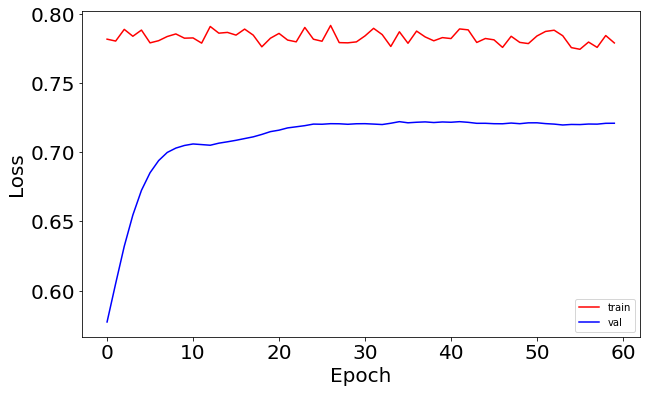

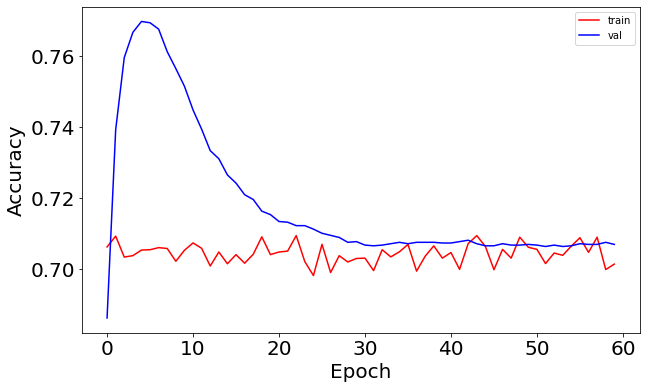

In [69]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

From the Loss plot, the validation set has an interesting positive exponential curve.  It is not encouraging that there is a loss rate so high for the Epochs after 7 that it is not availible on the graph.  

While the loss is not what is expected, the Accuracy plot shows that the accuracy scores for the validation  are unstable and bounce around the training accuracy in the first 10 epochs and then is set are above the accuracy score for the training set which lets us know the model has not been overfitted. 


The next model I will experiment with is the exponential decay model to experiment with a different learning rate function: 𝑙𝑟=𝑙𝑟₀ × 𝑒^(−𝑘𝑡)

In [70]:
# solution
epochs = 60
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

input_dim = X_train.shape[1]
num_classes = 2
batch_size = 196

# build the model
exponential_decay_model = Sequential()
optimizer = sgd
exponential_decay_model.add(Dense(384, input_dim = 42, activation = 'relu' ))
exponential_decay_model.add(BatchNormalization())
exponential_decay_model.add(Dropout(0.3))
exponential_decay_model.add(Dense(64, activation = 'relu'))
exponential_decay_model.add(BatchNormalization())
exponential_decay_model.add(Dropout(0.3))
exponential_decay_model.add(Dense(32, activation = 'relu'))
exponential_decay_model.add(BatchNormalization())
exponential_decay_model.add(Dropout(0.3))
exponential_decay_model.add(Dense(2, activation = 'softmax'))
#compile the model
exponential_decay_model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

                                
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# you invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model.fit(X_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(X_test, y_test))

Epoch 1/60
74/74 [==============================] - 2s 11ms/step - loss: 0.2823 - accuracy: 0.4176 - val_loss: 0.2859 - val_accuracy: 0.4465 - lr: 0.1000
Epoch 2/60
74/74 [==============================] - 0s 5ms/step - loss: 0.3506 - accuracy: 0.4532 - val_loss: 0.7202 - val_accuracy: 0.4997 - lr: 0.0905
Epoch 3/60
74/74 [==============================] - 0s 6ms/step - loss: 1.1514 - accuracy: 0.4786 - val_loss: 6.3878 - val_accuracy: 0.6205 - lr: 0.0819
Epoch 4/60
74/74 [==============================] - 0s 6ms/step - loss: 1.7340 - accuracy: 0.4795 - val_loss: 2.0383 - val_accuracy: 0.4355 - lr: 0.0741
Epoch 5/60
74/74 [==============================] - 0s 5ms/step - loss: 4.8674 - accuracy: 0.4696 - val_loss: 4.7785 - val_accuracy: 0.6086 - lr: 0.0670
Epoch 6/60
74/74 [==============================] - 0s 5ms/step - loss: 4.1250 - accuracy: 0.4727 - val_loss: 1.6845 - val_accuracy: 0.5175 - lr: 0.0607
Epoch 7/60
74/74 [==============================] - 0s 7ms/step - loss: 4.0160 - 

74/74 [==============================] - 1s 8ms/step - loss: 0.2659 - accuracy: 0.4382 - val_loss: 0.2492 - val_accuracy: 0.3806 - lr: 4.9916e-04
Epoch 55/60
74/74 [==============================] - 0s 6ms/step - loss: 0.2650 - accuracy: 0.4410 - val_loss: 0.2564 - val_accuracy: 0.3817 - lr: 4.5166e-04
Epoch 56/60
74/74 [==============================] - 1s 7ms/step - loss: 0.2647 - accuracy: 0.4356 - val_loss: 0.2526 - val_accuracy: 0.3814 - lr: 4.0868e-04
Epoch 57/60
74/74 [==============================] - 1s 12ms/step - loss: 0.2634 - accuracy: 0.4430 - val_loss: 0.2534 - val_accuracy: 0.3814 - lr: 3.6979e-04
Epoch 58/60
74/74 [==============================] - 1s 7ms/step - loss: 0.2652 - accuracy: 0.4466 - val_loss: 0.2516 - val_accuracy: 0.3809 - lr: 3.3460e-04
Epoch 59/60
74/74 [==============================] - 0s 6ms/step - loss: 0.2652 - accuracy: 0.4384 - val_loss: 0.2492 - val_accuracy: 0.3806 - lr: 3.0276e-04
Epoch 60/60
74/74 [==============================] - 0s 6ms/ste

Test loss: 0.2490587681531906
Test accuracy: 0.3806094229221344


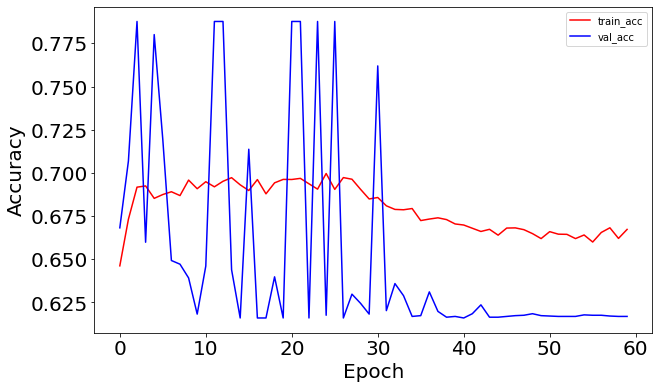

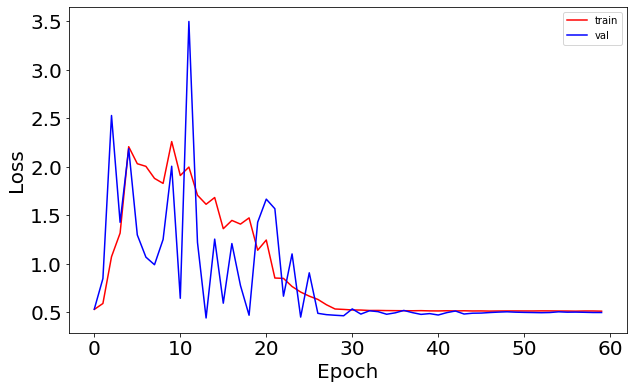

In [72]:
score = exponential_decay_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['accuracy']), 'r', label='train_acc')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_accuracy']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

With the learning rate scheduler in the form of exponential decay, the accuracy is lower than all previous models and the loss rate does not follow the exponential decay function. The function also plateaus very early on in the model and does not learn anymore. Therefore this exponential decay learning rate is not as efficient as the SGD learning rate, or the stable rate used previously

### Hyperparameter Tuning for Subclass Disorders

For the subclass disorder neural network I will look at the same type of Scheduled Learning Rates: Stochastic Gradient Descent and Exponential Decay. 

I will start with the Stochastic Gradient Descent and again the learning rate scheduler formula for the sgd is lr=lr×1/(1+decay∗epoch)

In [53]:
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [69]:
input_dim = X2_train.shape[1]

In [54]:
model2 = Sequential()
optimizer = sgd
model2.add(Dense(384, input_dim = 44, activation = 'relu' ))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(64, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(32, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(8, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [55]:
%%time
# Fit the model
batch_size = 512 #int(input_dim/100)

lr_model_history = model2.fit(X2_train, y2_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X2_test, y2_test))

Epoch 1/60
29/29 [==============================] - 2s 22ms/step - loss: 1.1849 - accuracy: 0.5140 - val_loss: 1.7419 - val_accuracy: 0.2970
Epoch 2/60
29/29 [==============================] - 0s 15ms/step - loss: 0.6312 - accuracy: 0.6837 - val_loss: 1.4642 - val_accuracy: 0.3906
Epoch 3/60
29/29 [==============================] - 0s 10ms/step - loss: 0.5912 - accuracy: 0.6999 - val_loss: 1.1456 - val_accuracy: 0.4961
Epoch 4/60
29/29 [==============================] - 0s 10ms/step - loss: 0.5838 - accuracy: 0.7020 - val_loss: 0.9393 - val_accuracy: 0.5626
Epoch 5/60
29/29 [==============================] - 0s 10ms/step - loss: 0.5720 - accuracy: 0.7060 - val_loss: 0.8210 - val_accuracy: 0.6061
Epoch 6/60
29/29 [==============================] - 0s 12ms/step - loss: 0.5731 - accuracy: 0.7050 - val_loss: 0.7132 - val_accuracy: 0.6413
Epoch 7/60
29/29 [==============================] - 0s 13ms/step - loss: 0.5634 - accuracy: 0.7120 - val_loss: 0.6623 - val_accuracy: 0.6413
Epoch 8/60
29

29/29 [==============================] - 0s 10ms/step - loss: 1.5882 - accuracy: 0.6036 - val_loss: 3.3776 - val_accuracy: 0.5903
Epoch 59/60
29/29 [==============================] - 0s 14ms/step - loss: 1.8325 - accuracy: 0.5655 - val_loss: 6.8850 - val_accuracy: 0.5742
Epoch 60/60
29/29 [==============================] - 0s 12ms/step - loss: 1.8047 - accuracy: 0.5955 - val_loss: 15.8577 - val_accuracy: 0.4861
CPU times: user 31.7 s, sys: 4.69 s, total: 36.4 s
Wall time: 23.5 s


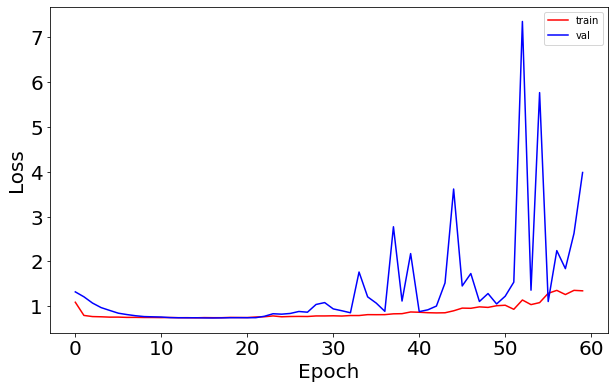

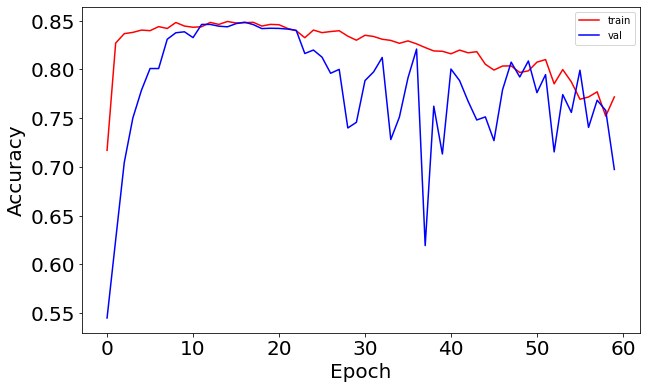

In [56]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [58]:
score = model2.evaluate(X2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 15.857719421386719
Test accuracy: 0.4861495792865753


The SGD learning rate scheduler has yeilded a much higher accuracy score seen for the subclass disorder model than has been seen. Unfortunately the loss is much higher as well, this brings into question whether the model is actually performing more efficiently. 

In [60]:
# solution
epochs = 60
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

input_dim = X2_train.shape[1]
num_classes = 8
batch_size = 196

# build the model

exponential_decay_model2 = Sequential()
optimizer = sgd
exponential_decay_model2.add(Dense(384, input_dim = 44, activation = 'relu' ))
exponential_decay_model2.add(BatchNormalization())
exponential_decay_model2.add(Dropout(0.3))
exponential_decay_model2.add(Dense(64, activation = 'relu'))
exponential_decay_model2.add(BatchNormalization())
exponential_decay_model2.add(Dropout(0.3))
exponential_decay_model2.add(Dense(32, activation = 'relu'))
exponential_decay_model2.add(BatchNormalization())
exponential_decay_model2.add(Dropout(0.3))
exponential_decay_model2.add(Dense(8, activation = 'softmax'))
#compile the model
exponential_decay_model2.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

                                
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# you invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model2.fit(X2_train, y2_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(X2_test, y2_test))

Epoch 1/60
74/74 [==============================] - 2s 10ms/step - loss: 0.9981 - accuracy: 0.5780 - val_loss: 1.3272 - val_accuracy: 0.4183 - lr: 0.1000
Epoch 2/60
74/74 [==============================] - 1s 7ms/step - loss: 0.6914 - accuracy: 0.6661 - val_loss: 1.0303 - val_accuracy: 0.5565 - lr: 0.0905
Epoch 3/60
74/74 [==============================] - 0s 6ms/step - loss: 0.6641 - accuracy: 0.6821 - val_loss: 0.8142 - val_accuracy: 0.6213 - lr: 0.0819
Epoch 4/60
74/74 [==============================] - 0s 6ms/step - loss: 0.6483 - accuracy: 0.6806 - val_loss: 0.6907 - val_accuracy: 0.6540 - lr: 0.0741
Epoch 5/60
74/74 [==============================] - 1s 9ms/step - loss: 0.6475 - accuracy: 0.6819 - val_loss: 0.6279 - val_accuracy: 0.6809 - lr: 0.0670
Epoch 6/60
74/74 [==============================] - 0s 6ms/step - loss: 0.6384 - accuracy: 0.6844 - val_loss: 0.5967 - val_accuracy: 0.6945 - lr: 0.0607
Epoch 7/60
74/74 [==============================] - 1s 7ms/step - loss: 0.6325 - 

74/74 [==============================] - 0s 6ms/step - loss: 0.6252 - accuracy: 0.6959 - val_loss: 0.5669 - val_accuracy: 0.7125 - lr: 4.9916e-04
Epoch 55/60
74/74 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6911 - val_loss: 0.5671 - val_accuracy: 0.7127 - lr: 4.5166e-04
Epoch 56/60
74/74 [==============================] - 1s 9ms/step - loss: 0.6261 - accuracy: 0.6893 - val_loss: 0.5670 - val_accuracy: 0.7125 - lr: 4.0868e-04
Epoch 57/60
74/74 [==============================] - 0s 7ms/step - loss: 0.6210 - accuracy: 0.6952 - val_loss: 0.5672 - val_accuracy: 0.7130 - lr: 3.6979e-04
Epoch 58/60
74/74 [==============================] - 0s 5ms/step - loss: 0.6245 - accuracy: 0.6925 - val_loss: 0.5670 - val_accuracy: 0.7127 - lr: 3.3460e-04
Epoch 59/60
74/74 [==============================] - 1s 9ms/step - loss: 0.6252 - accuracy: 0.6941 - val_loss: 0.5670 - val_accuracy: 0.7139 - lr: 3.0276e-04
Epoch 60/60
74/74 [==============================] - 1s 9ms/step

Test loss: 0.5671818852424622
Test accuracy: 0.7127423882484436


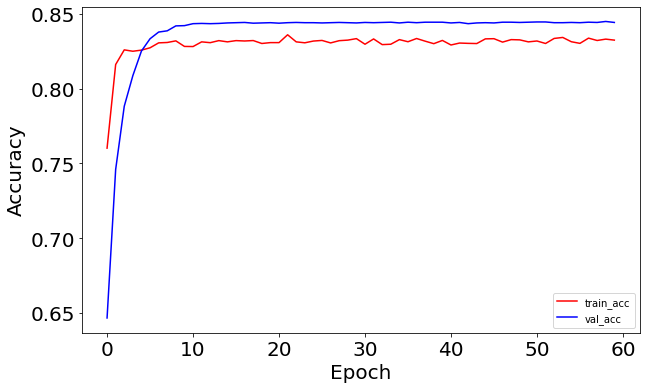

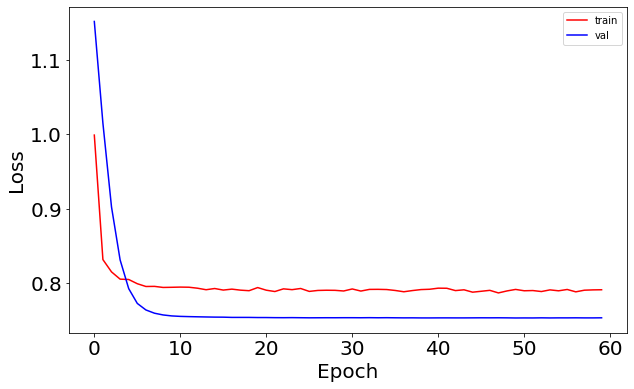

In [62]:
score = exponential_decay_model2.evaluate(X2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['accuracy']), 'r', label='train_acc')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_accuracy']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

The improvement seen on this model with the exponential decay learning rate scheduler is definitely significant compared to the previous optimzers of SGD and Adam. The loss function associated with the model is also good and what I would expect from a good model, with 0.56 as the test loss, and 0.712 as the test accuracy for the model. While it may not have accuracy above .90 the increase of about .55 is noteable and I can conclude that the model has been optimized best by the exponential decay learning rate scheduler. 